#### **Computer Vision**

Based on and with modifications from  of http://d2l.ai/

#### 1. Image Augmentation

In order to obtain definitve results during prediction, we applu image augmentation in training and not use augmentation during prediction. DL frameworks provide many augmentation methods that can be applied simultaneously.

In [ ]:
'''
Most image augmentation methods have a degree of randomness.
Common image augmentation methods
- flipping left and right, and Cropping
- changing color (brightness, contrast, saturation and hue)
- defining apply augmentation function (custom method)
- combining multiple image augmentation methods

We start with a method that runs augmentation multiple times on input iamge
'''
def apply(img, aug, num_rows=1, num_cols=6, scale=1.5):
    Y = [aug(img) for _ in range(num_cols * num_rows)]
    show_images(Y, num_rows, num_cols, scale=scale)

In [ ]:
shape_aug = torchvision.transforms.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))
color_aug = torchvision.transforms.ColorJitter(brightness=.1, contrast=0, saturation=0, hue=0.1)
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])

Training with Images

In [ ]:
all_imgs = torchvision.datasets.CIFAR10(train=True, root="../data", download=True)

100%|██████████| 170M/170M [00:19<00:00, 8.92MB/s]


In [ ]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),torchvision.transforms.ToTensor()])
test_augs = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

dataset = torchvision.datasets.CIFAR10(
        root="../data", train=True, transform=augs, download=True)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=4)

def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(
        root="../data", train=is_train, transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train, num_workers=4)
    return dataloader

In [ ]:
''' define a function to train and evaluate the model using multi-GPUs '''
def train_batch(model, X, y, loss, trainer, devices):
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    model.train()
    trainer.zero_grad()
    pred = model(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum

''' train wth multiple GPUs '''
def train(model, train_iter, test_iter, loss, trainer, num_epochs,
          devices=gpus):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['train loss', 'train acc', 'test acc'])
    num_batches = len(train_iter)
    net = nn.DataParallel(model, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        metric = Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss: {metric[0] / metric[2]:.3f}, train acc: {metric[1] / metric[2]:.3f}, '
          f'test acc: {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

In [ ]:
batch_size, devices, net = 256, gpus, resnet18(10, 3)
net.apply(init_cnn)

def train_with_augmented_data(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=0.1)
    net(next(iter(train_iter))[0]) #.to(devices[0]))
    train(net, train_iter, test_iter, loss, trainer, 10, devices)

loss: 0.210, train acc: 0.928, test acc: 0.853
511.4 examples/sec on ['cuda:0']


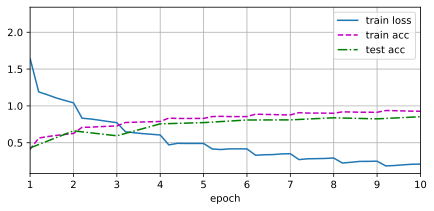

In [ ]:
train_with_augmented_data(train_augs, test_augs, net)